# Load data and annotations

In [1]:
from scipy.optimize import linear_sum_assignment
from scipy.special import softmax
def predict_label(model, temp_pos, temp_label, test_pos, temp_color=None, test_color=None, 
                  cuda=True, topn=5):

    # put template worm data and test worm data into a batch
    pt_batch = list()
    color_batch = list()

    pt_batch.append(temp_pos[:, :3])
    pt_batch.append(test_pos[:, :3])# here we can add more test worm if provided as a list.
    if temp_color is not None and test_color is not None:
        color_batch.append(temp_color)
        color_batch.append(test_color)
    else:
        color_batch = None
    data_batch = dict()
    data_batch['pt_batch'] = pt_batch
    data_batch['color'] = color_batch
    data_batch['match_dict'] = None
    data_batch['ref_i'] = 0

    model.eval()
    pt_batch = data_batch['pt_batch']
    with torch.no_grad():
        _, output_pairs = model(pt_batch, match_dict=None, ref_idx=data_batch['ref_i'], mode='eval')
    # p_m is the match of worms to the worm0
    i = 1
    p_m = output_pairs['p_m'][i].detach().cpu().numpy()
    num_neui = len(pt_batch[i])
    p_m = p_m[:num_neui, :]

    if data_batch['color'] is None:
        color_m = 0
    else:
        color_m = match_color_norm(data_batch['color'][data_batch['ref_i']], data_batch['color'][i]) * 60

    #p_m = p_m[:, :-1] + color_m * 1
    num_tmp = p_m.shape[1] - 1
    p_m = np.hstack((p_m[:, :-1], np.repeat(p_m[:, -1:], 20, axis=1)))
    row, col = linear_sum_assignment(-p_m)

    prob_m = softmax(p_m, axis=1)

    # most probable label
    test_label = [(-2, 0)] * num_neui
    for row_i in range(len(row)):
        if prob_m[row[row_i], col[row_i]] > 0.5 and col[row_i] < num_tmp:
            test_label[row[row_i]] = (temp_label[col[row_i]], prob_m[row[row_i], col[row_i]])
    candidate_list = []
    return test_label, candidate_list

In [8]:
from model import NIT_Registration
import torch
cuda = True
model = NIT_Registration(input_dim=3, n_hidden=128, n_layer=6, p_rotate=0, feat_trans=0, cuda=True)
device = torch.device("cuda:0" if cuda else "cpu")
# load trained model
model_path = "/projects/LEIFER/Xinwei/github/fDLC_Neuron_ID/model/model.bin"
params = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(params['state_dict'])
model = model.to(device)

In [3]:
import glob
import os
import numpy as np

path = '/projects/LEIFER/Xinwei/github/NeuronNet/pts_id/test_jeff_all2/real_jeff_all'
volumes = glob.glob(os.path.join(path, '*.npy'))
tmp_l = [(v, int(v.split('/')[-1].split('.')[0].split('_')[-1])) for v in volumes]
tmp_l.sort(key= lambda x:x[1])
volumes = [v[0] for v in tmp_l]


temp = np.load('/projects/LEIFER/Xinwei/github/NeuronNet/pts_id/test_jeff_all2/real_jeff_all/real_663.npy')
temp_pos, temp_label = temp[:, :3], temp[:, 3]
print('template labelled neurons:{}'.format(np.sum(temp[:, 3] > 0)))

label_array = np.ones((len(temp_pos), len(volumes))) * (-2)
label_array2 = np.ones((len(temp_pos), len(volumes))) * (-2)
temp_label2 = np.arange(len(temp_pos))
labelled_list = []
test_output = []
for v_i, v in enumerate(volumes):
    test = np.load(v)
    test_pos, test_label = test[:, :3], test[:, 3]

    test_label_pred, candidate_list = predict_label(model, temp_pos, temp_label2, test_pos, 
                                               temp_color=None, test_color=None, cuda=True, topn=5)
    test_output.append([int(v.split('/')[-1].split('.')[0].split('_')[-1]), test_label_pred])
    for neu_i, item in enumerate(test_label_pred):
        if item[0] >= 0:
            label_array[item[0], v_i] = test_label[neu_i]
            label_array2[item[0], v_i] = temp_label[item[0]]
    labelled_list.append(list(test_label))


template labelled neurons:70


In [4]:
stats = []
label_track = []
for n_i, cur_n in enumerate(label_array):
    count_d = dict()
    max_v = 0
    max_k = -1
    for l_i, l in enumerate(cur_n):
        if l in count_d:
            count_d[l] += 1
        else:
            count_d[l] = 1
        if count_d[l] > max_v:
            max_v = count_d[l]
            max_k = l
    if max_v < 1/3 * len(cur_n) or max_k < 0:
        continue
    # count the wrong fraction
    wrong_n = 0
    total_n = 0
    
    for l_i, l in enumerate(cur_n):
        if max_k in labelled_list[l_i] and (max_k in temp_label) and l>=-2: # -1
            total_n += 1
            if l != max_k:
                wrong_n += 1
    if total_n == 0:
        continue
    label_track.append((max_k, cur_n))
    stats.append([total_n, wrong_n, wrong_n / max(1, total_n), n_i])
label_track.sort(key=lambda x:x[0], reverse=True)
label_track = [cur[1] for cur in label_track]
label_track = np.array(label_track)

number:66


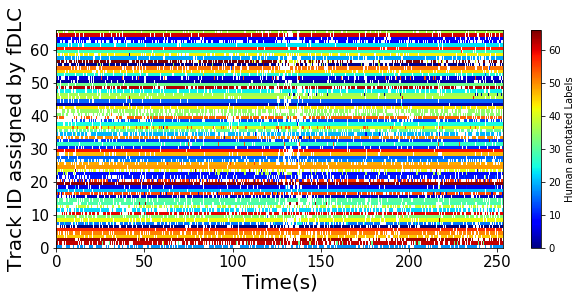

In [5]:
import colorcet as cc
import random
import matplotlib.pyplot as plt
    
label_track_random = np.copy(label_track)
label_track_random[label_track_random < 0] = np.nan # set untracked to be nan
mask = []  # get rid of neurons that are mostly untracked.
for cur in label_track_random:
    if np.sum(np.isnan(cur)) > 0.5 * len(cur):
        mask.append(False)
    else:
        mask.append(True)
label_track_random = label_track_random[mask, :]

# correct the color label # some are unused and it makes reader think we don't track all
l_max = int(np.max(label_track))

count_l = [0 for _ in range(l_max+1)]
for i in range(label_track_random.shape[0]):
    for j in range(label_track_random.shape[1]):
        if not np.isnan(label_track_random[i, j]):
            count_l[int(label_track_random[i, j])] += 1
l_d = dict()  # use l_d to map to new label
count = 0
for ci, c in enumerate(count_l):
    if c > 100:
        l_d[ci] = count
        count += 1
    
        
for i in range(label_track_random.shape[0]):
    for j in range(label_track_random.shape[1]):
        if (not np.isnan(label_track_random[i, j])):
            if int(label_track_random[i, j]) in l_d:
                label_track_random[i, j] = l_d[int(label_track_random[i, j])]
            else:
                label_track_random[i, j] = np.nan

# shuffle the label_track
l_shuffle = [i for i in range(label_track_random.shape[0])]
random.shuffle(l_shuffle)
label_track_random = label_track_random[l_shuffle, :]

plt.figure(figsize=(10, 4))
# plt.imshow(label_track_random, cmap=cc.m_fire, aspect='auto', 
#            extent=[0, label_track_random.shape[1] / 6, 0, label_track_random.shape[0]])
label_show = label_track_random
print('number:{}'.format(label_show.shape[0]))
plt.imshow(label_show, cmap='jet', aspect='auto', 
           extent=[0, label_show.shape[1] / 6, 0, label_show.shape[0]])

#xticks = np.arange(0, label_track_random.shape[1], 140) / 6
plt.xticks(fontsize=15)
plt.xlabel('Time(s)', fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Track ID assigned by fDLC', fontsize=20)
plt.colorbar(label='Human annotated Labels')
plt.show()

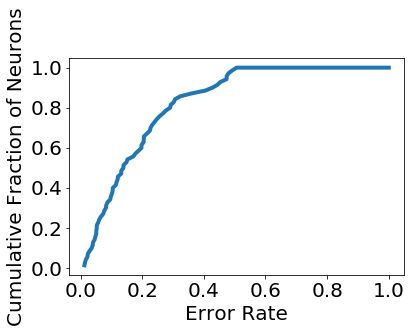

In [6]:
tmp = list(np.array(stats)[:, 2])
tmp.sort()
error_rate_sort = tmp
cdf_x = []
cdf_y = []
count = 0
num_total = len(tmp)
for e in error_rate_sort:
    cdf_x.append(e)
    count += 1
    cdf_y.append(count / num_total)
cdf_x.append(1)
cdf_y.append(1)
plt.plot(cdf_x, cdf_y, linewidth=4)
plt.xticks(fontsize=20)
plt.xlabel('Error Rate', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Cumulative Fraction of Neurons', fontsize=20)
plt.show()
